### Spikes coupled to LFP

In [1]:
import sys

sys.path.insert(1, "/home/INT/lima.v/projects/phase_amplitude_encoding/")

In [28]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.models_setup import _set_nodes, _set_nodes_delayed
from src.utils import randn

#### Functions

In [3]:
jax.config.update("jax_enable_x64", True)


def _check_params(Iext: jnp.ndarray, N: int):
    if isinstance(Iext, (int, float)):
        return jnp.ones((1, N)) * Iext  # Assure it is a jax ndarray
    elif Iext is None:
        return jnp.zeros((1, N))
    return jnp.asarray(Iext)


def _ode(Z: np.complex128, a: float, w: float):
    return Z * (a + 1j * w - jnp.abs(Z) ** 2)


def ode_spikes(v, vr, tau):
    return -(v - vr) / tau

In [4]:
def simulate_SpikeLFP(
    lfp2spike: float,
    f: float,
    a: float,
    vth: float,
    vr: float,
    tau: float,
    fs: float,
    eta: float,
    T: float,
    seed: int = 0,
    device: str = "cpu",
    decim: int = 1,
):

    assert device in ["cpu", "gpu"]

    jax.config.update("jax_platform_name", device)

    dt = 1 / fs

    times = np.arange(T, dtype=int)  # Time array

    omega = 2 * jnp.pi * f

    # Initialize phase and membrane potential
    z = dt * np.random.uniform() + 1j * dt * np.random.uniform()
    v_t = np.random.uniform() * (vth - vr) + vr
    x_t = False

    # Neuron noise parameter
    R = 50.0  # Membrane resistence in Mohm
    sigma = 2.12  # Noise variance
    Cm = tau / R
    x_ex = jnp.exp(dt / tau)

    mu_v = 14.2 / R
    sigma_v = sigma * (Cm / tau) * jnp.sqrt((1 + x_ex) / (1 - x_ex))

    # Scale with dt to avoid doing it evert time-step
    eta = eta * jnp.sqrt(dt)

    # @jax.jit
    def _loop(carry, t):

        z, v_t, x_t = carry

        z = (
            z
            + dt * _ode(z, a, omega)
            + eta * randn(size=1, seed=seed + t)[0]
            + eta * 1j * randn(size=1, seed=seed + t + 2 * t)[0]
        )

        v_t = (
            v_t
            + dt * ode_spikes(v_t, vr, tau)
            + jnp.sqrt(dt) * (mu_v + sigma * randn(size=1, seed=seed + t + 15)[0])
            + dt * lfp2spike * jax.nn.relu(z.real * 1e6)
        )

        x_t = v_t >= vth

        v_t = x_t * vr + (1 - x_t) * v_t

        carry = (z, v_t, x_t)
        return carry, (z, v_t, x_t)

    _, out = jax.lax.scan(_loop, (z, v_t, x_t), times)

    return out[0][::decim], out[1][::decim], out[2][::decim]

In [72]:
def simulate_SpikeLFP_network(
    W: float,
    M: float,
    G: float,
    E: float,
    g,
    f: float,
    a: float,
    vth: float,
    vr: float,
    tau: float,
    fs: float,
    eta: float,
    T: float,
    seed: int = 0,
    device: str = "cpu",
    decim: int = 1,
):

    assert device in ["cpu", "gpu"]

    jax.config.update("jax_platform_name", device)

    # Number of regions
    N = len(W)

    g = _check_params(g, T).squeeze()
    eta = _check_params(eta, N).squeeze()

    # Temporal resolution
    dt = 1 / fs

    # Time array
    times = np.arange(T, dtype=int)  # Time array

    omega = 2 * jnp.pi * f

    # Initialize phase and membrane potential
    z = dt * np.random.uniform(size=(N, 1)) + 1j * dt * np.random.uniform(size=(N, 1))
    v = np.random.uniform(size=(N, 1)) * (vth - vr) + vr
    x = np.zeros((N, 1), dtype=jnp.bool)

    # Neuron noise parameter
    R = 50.0  # Membrane resistence in Mohm
    sigma = 2.12 * jnp.sqrt(dt)  # Noise variance
    mu_v = 14.2 / R * jnp.sqrt(dt)

    # Scale with dt to avoid doing it evert time-step
    eta = eta * jnp.sqrt(dt)

    # Scale with dt to avoid doing it evert time-step
    W = W * dt
    M = M * dt
    G = G * dt
    E = E * dt

    # @jax.jit
    def _loop(carry, t):

        z, v, x = carry

        z_t = z.squeeze().copy()
        v_t = v.squeeze().copy()
        x_t = x.squeeze().copy()

        z_differences = z_t - z

        # Input to each node
        input_LFP = g[t] * (W * z_differences).sum(axis=1)
        input_SPIKES2LFP = g[t] * (G * x_t).sum(axis=1)
        input_SPIKES = g[t] * (M * x_t).sum(axis=1) / tau

        z = z.at[:, 0].set(
            z_t
            + dt * _ode(z_t, a, omega)
            + input_LFP
            + input_SPIKES2LFP
            + eta * randn(size=(N,), seed=seed + t)
            + eta * 1j * randn(size=(N,), seed=seed + t + 2 * t)
        )

        v = v.at[:, 0].set(
            v_t
            + dt * ode_spikes(v_t, vr, tau)
            + input_SPIKES
            + mu_v
            + sigma * randn(size=(N,), seed=seed + t + 15)
            + E * jax.nn.relu(z_t.real * 1e6)
        )

        # Check threshold crossing
        x = v >= vth
        v = x * vr + (1 - x) * v

        carry = (z, v, x)
        return carry, (z, v, x)

    _, out = jax.lax.scan(_loop, (z, v, x), times)

    return out[0][..., ::decim], out[1][..., ::decim], out[2][..., ::decim]

#### One region

In [5]:
out = [
    simulate_SpikeLFP(5, 40, -5, -50, -70, 20, 1 / 1e-4, 1e-4, 100000, seed=i + 20546)
    for i in tqdm(range(300))
]

100%|█████████████████████████████████████████| 300/300 [01:53<00:00,  2.64it/s]


In [6]:
z = np.stack([out_[0].real for out_ in out])
x = np.stack([out_[2] for out_ in out])

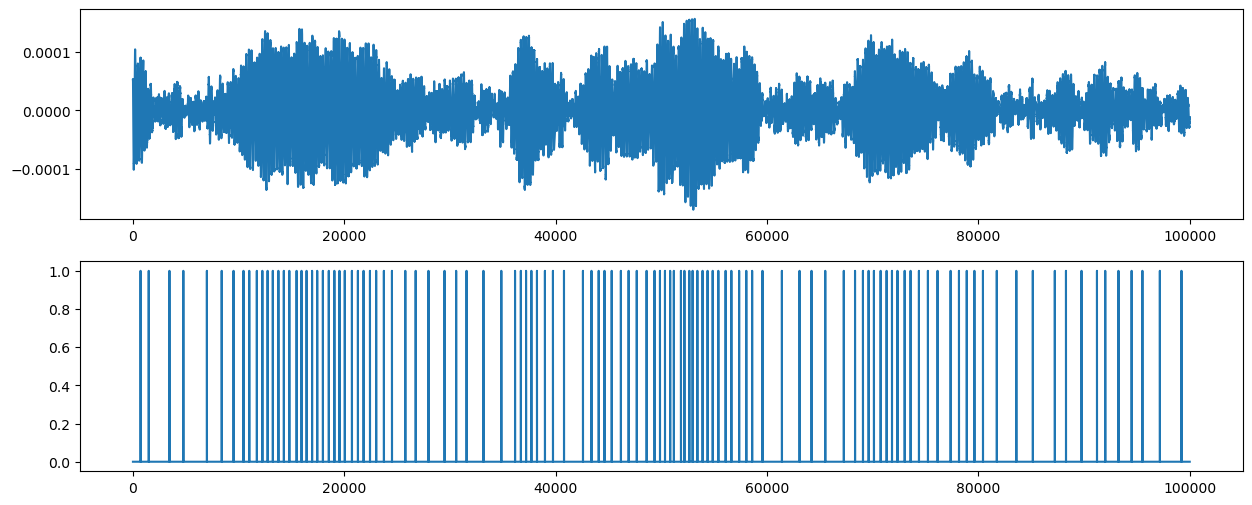

In [7]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(z[0])
plt.subplot(2, 1, 2)
plt.plot(x[0])

In [8]:
import scipy.io as sio
import statsmodels.api as sm
from pylab import *
from scipy import signal, stats

In [9]:
dt = 1e-4


def coherence(n, y, t):  # INPUT (spikes, fields, time)
    K = np.shape(n)[0]  # ... where spikes and fields are arrays [trials, time]
    N = np.shape(n)[1]
    T = t[-1]
    SYY = np.zeros(int(N / 2 + 1))
    SNN = np.zeros(int(N / 2 + 1))
    SYN = np.zeros(int(N / 2 + 1), dtype=complex)

    for k in arange(K):
        yf = rfft((y[k, :] - mean(y[k, :])) * hanning(N))  # Hanning taper the field,
        nf = rfft((n[k, :] - mean(n[k, :])))  # ... but do not taper the spikes.
        SYY = SYY + (real(yf * conj(yf))) / K  # Field spectrum
        SNN = SNN + (real(nf * conj(nf))) / K  # Spike spectrum
        SYN = SYN + (yf * conj(nf)) / K  # Cross spectrum

    cohr = abs(SYN) / sqrt(SYY) / sqrt(SNN)  # Coherence
    f = rfftfreq(N, dt)  # Frequency axis for plotting

    return (cohr, f, SYY, SNN, SYN)

In [10]:
cohr, f, SYY, SNN, SYN = coherence(x, z, np.arange(0, 10000, 1e-4))

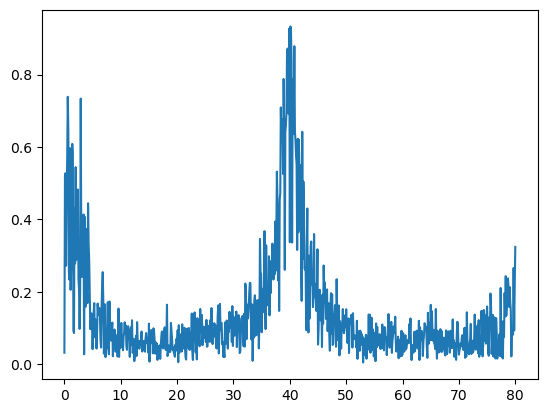

In [11]:
plt.plot(f[f <= 80], cohr[f <= 80])

#### Two regions

In [291]:
W = jnp.array([[0, 1], [0, 0]]).T * 30
M = jnp.array([[0, 1], [0, 0]]).T * 0.25
G = jnp.array([[0, 1], [0, 0]]).T * 3
E = jnp.array([15, 15])

g = 1
f = jnp.array([40, 40])
a = -10
vth = -50
vr = -70
tau = 20
fs = 1 / 1e-4
eta = 1e-4
T = 50000

In [292]:
z, v, x = simulate_SpikeLFP_network(W, M, G, E, g, f, a, vth, vr, tau, fs, eta, T)

Text(0, 0.5, 'Spike Train')

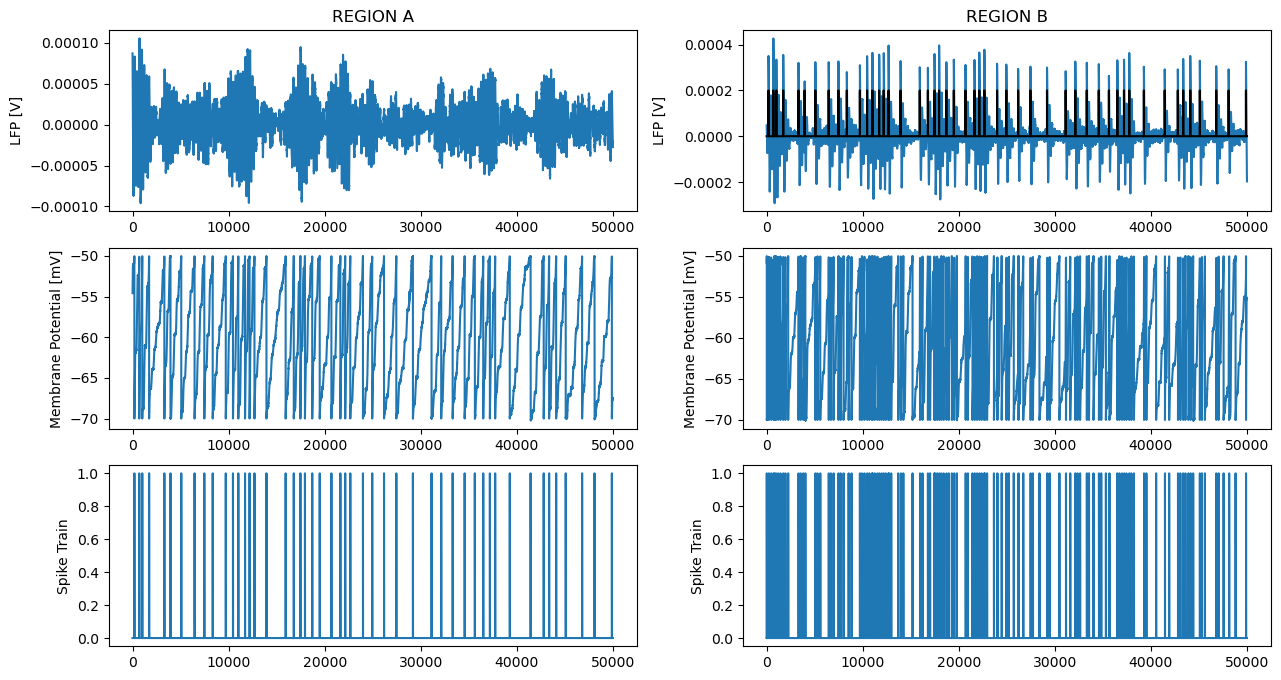

In [293]:
plt.figure(figsize=(15, 8))
# LFP
plt.subplot(3, 2, 1)
plt.plot(z.real[:, 0])
plt.title("REGION A")
plt.ylabel("LFP [V]")
plt.subplot(3, 2, 2)
plt.plot(z.real[:, 1])
plt.plot(x[:, 0] / 5000, c="k")

plt.title("REGION B")
plt.ylabel("LFP [V]")


# POTENTIAL
plt.subplot(3, 2, 3)
plt.plot(v[:, 0])
plt.ylabel("Membrane Potential [mV]")
plt.subplot(3, 2, 4)
plt.plot(v[:, 1])
plt.ylabel("Membrane Potential [mV]")

# SPIKE TRAIN
plt.subplot(3, 2, 5)
plt.plot(x[:, 0])
plt.ylabel("Spike Train")
plt.subplot(3, 2, 6)
plt.plot(x[:, 1])
plt.ylabel("Spike Train")


In [294]:
from mne.time_frequency.tfr import tfr_array_morlet

In [295]:
z.real[:, 1].shape

(50000, 1)

In [296]:
psd, f = psd_array_multitaper(z.real[:, 1].squeeze(), 1 / 1e-4, fmax=80)

    Using multitaper spectrum estimation with 7 DPSS windows


In [297]:
freqs = np.linspace(.1, 80, 50)
out = tfr_array_morlet(z.real[:, 1].squeeze()[None, None], 1 / 1e-4, freqs, freqs / 4, output="power").squeeze()

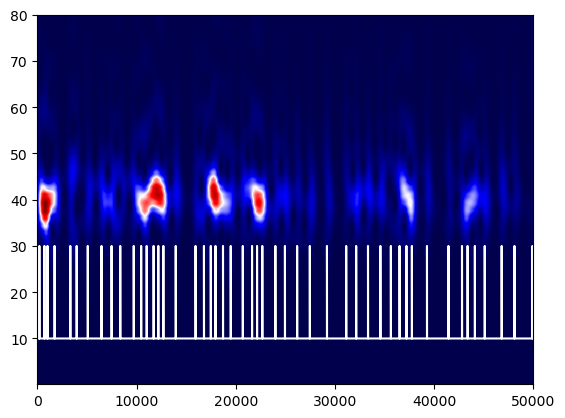

In [298]:
plt.plot(x[:, 0] * 20 + 10, c="w")
plt.imshow(out, aspect="auto", origin="lower", cmap="seismic", extent=[0, len(x[:, 0]), .1, 80])

